In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
### 256, pas augment, 15% dataset, res18, 5 epoch ==> 0.76 error rate en 5 epoch
### 256,     augment, 15% dataset, res18, 5 epoch ==> 0.74 error rate en 5 epoch
### 512,     augment, 15% dataset, res18, 5 epoch ==> 0.59 error rate en 5 epoch#
### 512,     augment, 15% dataset, res34,50 epoch ==> 0.02 error rate en 50 epoch# ==> O.35 dans la leaderborad, problème val-set non représentatif 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

In [2]:
from fastai.vision.all import *
path = "/home/remi/Documents/kaggle_data/train_images/"
files = get_image_files(path)

In [4]:
import random
split_file = []
for f in files:
    if random.random()< 2:
        split_file.append(f)

In [6]:
f = open("/home/remi/Documents/kaggle_data/train_cultivar_mapping.csv","r")
f.readline()
image_to_category = {}
for i in f.readlines():
    split = i.split(",")
    image_to_category[split[0]]= split[1].replace("\n", "")
    #print(i.split(","))
f.close()

In [7]:
def label_func(path_obj):
    return image_to_category[os.path.basename(path_obj)]

In [8]:
dls = ImageDataLoaders.from_name_func(path, split_file, label_func, item_tfms=Resize(64*4*2),bs=32,batch_tfms=aug_transforms())

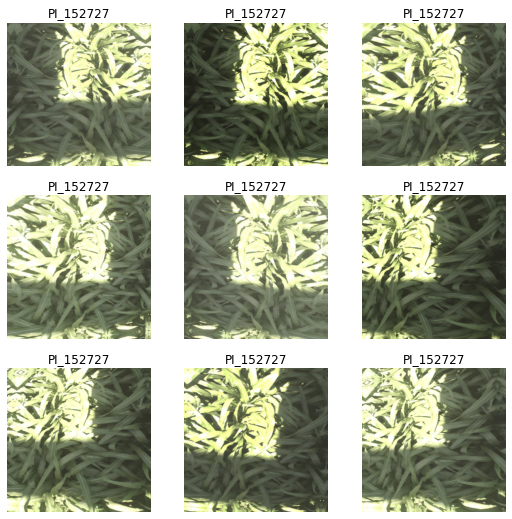

In [9]:
dls.show_batch(unique=True)

In [10]:
dls.bs, len(split_file)

(32, 22193)

SuggestedLRs(valley=0.001737800776027143)

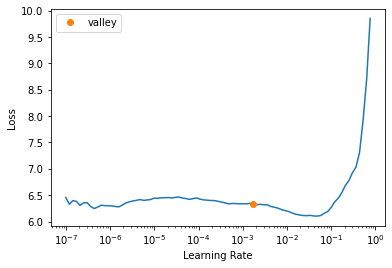

In [12]:
learn = vision_learner(dls, resnet34, metrics=error_rate  )
learn.lr_find()

In [13]:
learn.fine_tune(50,0.0017,freeze_epochs=3,cbs=[SaveModelCallback()])

epoch,train_loss,valid_loss,error_rate,time
0,4.698153,3.537463,0.829653,05:06
1,3.020892,2.253813,0.583146,05:06
2,2.258179,1.775057,0.488058,05:09


Better model found at epoch 0 with valid_loss value: 3.5374629497528076.
Better model found at epoch 1 with valid_loss value: 2.2538130283355713.
Better model found at epoch 2 with valid_loss value: 1.7750574350357056.


epoch,train_loss,valid_loss,error_rate,time
0,1.423704,1.196265,0.338441,06:16
1,1.161240,0.897612,0.260928,06:17
2,0.959782,0.739515,0.217440,06:17
3,0.757655,0.697271,0.211807,06:18
4,0.687311,0.686720,0.211582,06:20
5,0.578331,0.491488,0.153898,06:19
6,0.518191,0.463487,0.145786,06:16
7,0.485072,0.420256,0.130239,06:17
8,0.421950,0.601753,0.187472,06:17
9,0.417732,0.339360,0.108382,06:16


Better model found at epoch 0 with valid_loss value: 1.1962648630142212.
Better model found at epoch 1 with valid_loss value: 0.8976118564605713.
Better model found at epoch 2 with valid_loss value: 0.7395151257514954.
Better model found at epoch 3 with valid_loss value: 0.6972713470458984.
Better model found at epoch 4 with valid_loss value: 0.6867199540138245.
Better model found at epoch 5 with valid_loss value: 0.49148818850517273.
Better model found at epoch 6 with valid_loss value: 0.4634871780872345.
Better model found at epoch 7 with valid_loss value: 0.42025646567344666.
Better model found at epoch 9 with valid_loss value: 0.339359849691391.
Better model found at epoch 18 with valid_loss value: 0.2469947338104248.
Better model found at epoch 22 with valid_loss value: 0.24401739239692688.
Better model found at epoch 23 with valid_loss value: 0.24237583577632904.
Better model found at epoch 25 with valid_loss value: 0.2395188957452774.
Better model found at epoch 26 with valid_lo

In [14]:
learn.load("/home/remi/Documents/kaggle_data/train_images/models/model")

/home/remi/anaconda3/envs/fastaiv2GPU/lib/python3.8/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [15]:
tst_files = get_image_files("/home/remi/Documents/kaggle_data/test/").sorted()
tst_dl = dls.test_dl(tst_files)

In [16]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

tensor([52, 93, 99,  ..., 22,  4, 67])

In [19]:
list_df =[] 
list_cultivar =[] 

for i in tqdm(range(len(tst_files))):#    len(tst_files)):
    list_df.append(os.path.basename(tst_files[i]))
    list_cultivar.append(dls.vocab[idxs[i]])


100%|██████████| 23639/23639 [00:01<00:00, 14333.86it/s]


In [20]:
import pandas as pd
d = {'filename': list_df, 'cultivar': list_cultivar}
df = pd.DataFrame(d)
df

,filename,cultivar
0,1000005362.png,PI_180348
1,1000099707.png,PI_329333
2,1000135300.png,PI_92270
3,1000136796.png,PI_329256
4,1000292439.png,PI_273969
...,...,...
23634,999578153.png,PI_156217
23635,999692877.png,PI_273465
23636,999756998.png,PI_152967
23637,999892248.png,PI_146890


In [21]:
df.to_csv('submissionRemi.csv', index=False)